# squat deadlift regression
The below notebook will show the relationship between back squat and deadlift for CrossFit athletes based on the information provided by their athlete profiles. The division under examination is Women (45-49), seeing as this is the largest COMPLETE dataset at the time of writing this code.

## imports

In [147]:
#pandas (dataframes)
import pandas as pd
#pymysql (mysql connector)
import pymysql as pms
#numpy (reshaping data)
import numpy as np
#scikit-learn (linear regression, train/test splits)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#plotting
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# use for implementing custom modules
import sys
sys.path.insert(0, "../custom_modules/")

#custom modules
#grabbing data
from dataframer import grab_data
#seaborn styling
import seaborn_styler as sbs

## getting database credentials

In [7]:
#this list object is passed around to functions requiring database access
#...the functions will open/close the connection themselves during calls
creds = []
#database credentials are stored in this file
with open("../database_credentials2.txt") as f:
    db_user = f.readline().strip()
    db_pass = f.readline().strip()
    db_name = f.readline().strip()
    db_host = f.readline().strip()
    creds = [db_host, db_user, db_pass,db_name]

## grabbing the data

In [8]:
#read into dataframe
#note: division 4 references women 45-49
squat_deadlift = grab_data(
    """
    SELECT back_squat_lbs AS squat, deadlift_lbs AS deadlift
    FROM athlete
    WHERE division_id=4
    AND back_squat_lbs > 0
    AND deadlift_lbs > 0;
    """,
    creds
)

### quick summary

In [9]:
#first 5 entries
squat_deadlift.head(5)

,squat,deadlift
0,210,305
1,215,300
2,255,340
3,202,275
4,215,305


In [10]:
#pandas inherit statistical descriptor function for pandas dataframes
squat_deadlift.describe()

,squat,deadlift
count,1075.000000,1075.000000
mean,198.645581,251.718140
std,38.392562,43.168152
min,70.000000,110.000000
25%,175.000000,220.000000
50%,198.000000,245.000000
75%,225.000000,285.000000
max,396.000000,385.000000


## splitting data into train/test sets

In [21]:
#ratio of data to be used for testing
test_ratio = .2
#random state used for ML initialization
random_state = 0

In [22]:
#doesn't really matter which variable is used here as (in)dependent
x_train, x_test, y_train, y_test = train_test_split(
    #x
    squat_deadlift.squat,
    #y
    squat_deadlift.deadlift,
    test_size=test_ratio,
    random_state=random_state
)

## linear regression
Below we apply scikit-learn's [linear regression](http://scikit-learn.org/stable/auto_examples/plot_isotonic_regression.html#sphx-glr-auto-examples-plot-isotonic-regression-py) to the squat/deadlift data, using squat weight (in lbs) to predict deadlift weight (in lbs). Note that these values are 1 rep maxes (the maximum amount of weight an athlete has attested to lifting for 1 rep).

In [23]:
regressor = LinearRegression()
regressor.fit(x_train[:, np.newaxis], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### stylize seaborn
This only needs to be done once, and can be done anywhere. I'm just leaving it till here because this is the first time we're plotting something in this notebook.

In [24]:
sbs.stylize()

### plotting regression
The data can be plotted using Seaborn's [regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html).

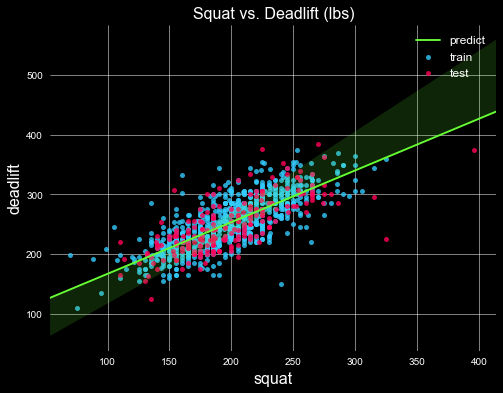

In [130]:
#colors for plotting
color_map = {
    "scatter": {
        "train": "#33ccff",
        "test": "#ff0059"
    },
    "regression": {
        "predict": "#66ff33"
    }
}

#training/testing dataframes
df_train = pd.concat([x_train, y_train], axis=1)
df_test = pd.concat([x_test, y_test], axis=1)
df_preds = pd.DataFrame(x_test.values, columns=["squat"])
df_preds["deadlift"] = pd.Series(regressor.predict(x_test.values[:, np.newaxis]))

#used to make plotting less repetitive
colors_scatter = [color_map["scatter"]["train"], color_map["scatter"]["test"]]
labels = ["train", "test"]
dfs = [df_train, df_test]

#plotting scatter plots
for i in range(len(dfs)):
    ax = sb.regplot(
        x="squat",
        y="deadlift",
        data=dfs[i],
        fit_reg=False,#default true
        color=colors_scatter[i],
        scatter_kws={"s": 25},
        label=labels[i],
        marker="o"
    )

#plotting regression (from model predicting based on x_test)
ax = sb.regplot(
    x="squat",
    y="deadlift",
    data=df_preds.head(2),
    scatter=False,#default true
    color=color_map["regression"]["predict"],
    label="predict"
)
plt.title("Squat vs. Deadlift (lbs)")
plt.legend()
plt.show()
#testing data
#ax = sb.regplot(x="squat", y="deadlift", data=df_test, fit_reg=False, color=colors["scatter"]["test"])

## analyzing regression fit
The regression looks like it fits the data well, but because the data has a decent spread, let's use some metrics to analyze it's performance.

In [149]:
#r2
print(
    "R2 score: {}".format(
        regressor.score(
            df_test["squat"][:, np.newaxis],
            df_test["deadlift"][:, np.newaxis]
        )
    )
)

#rmse
print(
    "RMSE: {}".format(
        mean_squared_error(
            df_test["deadlift"][:, np.newaxis],
            df_preds["deadlift"][:, np.newaxis]
        )
    )
)

R2 score: 0.5314344987427346
RMSE: 942.0932860296303


Analyziing the R2 specifically, it seems as though only 50% of the variation in deadlifts observed in the women's 45-49 division can be explained by looking at the back squat. Because of this, observing the back squat alone is most likely not a strong enough metric to try and predict athlete deadlifts. However, explaining 50% of the deadlift variation IS significant. Perhaps this regression could be done again, taking into account cleans, snatches, or 2k rows.